In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_addons as tfa
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Dropout, RepeatVector, Bidirectional, ELU, TimeDistributed, Lambda, Layer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras import regularizers, losses
from tensorflow.keras import backend as K
import gzip
import os
import datetime
import random

tf.compat.v1.disable_eager_execution()

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# import dataset from txt file

X = np.array(())

DataSetPath = '/content/gdrive/My Drive/bsc/Final/DataSet/ferdousi_norm.txt'

dataset = pd.read_csv(DataSetPath, na_values=" ", header=None)
temp = dataset.iloc[:, 0].values

X = np.append(X, temp)

In [4]:
print(X[:3])
print(X[-1])
print(X[-2])

['به نام خداوند جان و خرد' 'کزین برتر اندیشه برنگذرد'
 'خداوند نام و خداوند جای']
هر آنکس که دارد هش و رای و دین
که تخم سخن من پراگنده ام


In [5]:
print("The total count of masraas is " , len(X))

The total count of masraas is  99217


In [6]:
# Train on just a quarter of data
X = X[: int(len(X) / 4) ]

if len(X) % 2 == 1:
    X = X[:-1]

In [7]:
print("The total count of masraas is " , len(X))

The total count of masraas is  24804


In [8]:
verses = []
input_verses = []

for i in range(len(X)):
    if i % 2 == 0:
        input_verses.append(X[i] + ' <middle> ' + X[i + 1] + ' <eos>')
        verses.append(X[i] + ' <middle> ' + X[i + 1] + ' <eos>')

In [9]:
print("The total number of verses is ", len(verses))

The total number of verses is  12402


In [10]:
# tokenize all data

tokenizer = Tokenizer(filters="")
tokenizer.fit_on_texts(verses)

TokenizedVerses = tokenizer.texts_to_sequences(verses)
tokenized_input = tokenizer.texts_to_sequences(input_verses)

In [11]:
word2index = tokenizer.word_index
index2word = tokenizer.index_word

In [12]:
# find max length for padding

max_len = 0

for i in tokenized_input:
    if len(i) > max_len:
        sen = []
        for t in i :
            sen.append(index2word[t])
        print(sen)
    max_len = max(max_len, len(i)) 

print("maximum length of sentences : ", max_len)


['به', 'نام', 'خداوند', 'جان', 'و', 'خرد', '<middle>', 'کزین', 'برتر', 'اندیشه', 'برنگذرد', '<eos>']
['خداوند', 'کیوان', 'و', 'گردان', 'سپهر', '<middle>', 'فروزنده', 'ماه', 'و', 'ناهید', 'و', 'مهر', '<eos>']
['نیابد', 'بدو', 'نیز', 'اندیشه', 'راه', '<middle>', 'که', 'او', 'برتر', 'از', 'نام', 'و', 'از', 'جایگاه', '<eos>']
['خرد', 'را', 'و', 'جان', 'را', 'همی', 'سنجد', 'اوی', '<middle>', 'در', 'اندیشه', 'سخته', 'کی', 'گنجد', 'اوی', '<eos>']
['سه', 'پاس', 'تو', 'چشم', 'است', 'وگوش', 'و', 'زبان', '<middle>', 'کزین', 'سه', 'رسد', 'نیک', 'و', 'بد', 'بی', 'گمان', '<eos>']
['نه', 'کند', 'آوری', 'گیرد', 'از', 'باج', 'و', 'گنج', '<middle>', 'نه', 'دل', 'تیره', 'دارد', 'ز', 'رزم', 'و', 'ز', 'رنج', '<eos>']
['ز', 'گنج', 'و', 'ز', 'تخت', 'و', 'ز', 'در', 'و', 'گهر', '<middle>', 'ز', 'اسپ', 'و', 'سلیح', 'و', 'کلاه', 'و', 'کمر', '<eos>']
['به', 'دیبا', 'و', 'دینار', 'و', 'در', 'و', 'درم', '<middle>', 'به', 'بوی', 'و', 'به', 'رنگ', 'و', 'به', 'هر', 'بیش', 'و', 'کم', '<eos>']
maximum length of sentence

In [13]:
# do padding

input_seq = pad_sequences(tokenized_input, maxlen=max_len, padding='post')

In [14]:
# building model
class AE(object):
    def build_model(self, vocab_size, timesteps, intermediate_dim, latent_dim):

        """
        Creates an LSTM Variational Autoencoder (VAE). Returns VAE, Encoder, Generator. 
        # Arguments
            timesteps: int, input timestep dimension. e.g sentences max size
            intermediate_dim: int, output shape of LSTM. 
            latent_dim: int, latent z-layer shape. 
        # References
            - [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
        """
        
        self.ae = None
        self.encoder = None
        self.generator = None
        
        x = Input(shape=(timesteps,))
        embed = Embedding(vocab_size, 256, input_length=timesteps)(x)

        # LSTM encoding
        h = Bidirectional(LSTM(intermediate_dim, activation="relu", kernel_regularizer=regularizers.l2(0.001), return_sequences=True), merge_mode="concat")(embed)
        h = Bidirectional(LSTM(intermediate_dim, activation="relu", kernel_regularizer=regularizers.l2(0.001)), merge_mode="concat")(h)
        h = Dense(intermediate_dim, activation='linear')(h)
        h = ELU()(h)

        # AE Z layer
        z = Dense(latent_dim)(h)
        
        # decoded LSTM layer
        repeated_context = RepeatVector(timesteps)
        decoder_h = LSTM(intermediate_dim, return_sequences=True, kernel_regularizer=regularizers.l2(0.001))
        decoder_mean = TimeDistributed(Dense(vocab_size, activation='softmax')) 

        h_decoded = decoder_h(repeated_context(z))
        x_decoded_mean = decoder_mean(h_decoded)

        # end-to-end autoencoder
        self.ae = Model(x, x_decoded_mean)

        # encoder, from inputs to latent space
        self.encoder = Model(x, z)

        # generator, from latent space to reconstructed inputs
        decoder_input = Input(shape=(latent_dim))

        _h_decoded = decoder_h(repeated_context(decoder_input))

        _x_decoded_mean = decoder_mean(_h_decoded)
        self.generator = Model(decoder_input, _x_decoded_mean)
        
        opt = Adam(lr=0.01) #SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
        
        self.ae.compile(optimizer='adam', loss="sparse_categorical_crossentropy")



In [15]:
base_path = "/content/gdrive/My Drive/bsc/Final/GAN/"
!ls "/content/gdrive/My Drive/bsc/Final/GAN/"

AE


In [16]:
!tail "/content/gdrive/My Drive/bsc/Final/GAN/AE/reconstruct_sentences_during_training.txt" 

برفت و بدو داد تخت و کلاه <middle> بزرگی و دیهیم و گنج و سپاه <eos> ==> سلیح و کشور تاج تخت و کلاه <middle> بزرگی و تاج و تاج و سر <eos>
 Training: epoch 497 ends at 08:01:33.204708 
reconstruct text via predict : 
چو خورشید بر تیغ گنبد شود <middle> گه خواب و خورد سپهبد شود <eos> ==> چو آمد به نزدیک درنده دلیر <middle> که شد اندرون همه نره روان <eos>
 Training: epoch 498 ends at 08:02:50.300466 
reconstruct text via predict : 
اگر باشد این نیست کاری شگفت <middle> که چندین بد اندیشه باید گرفت <eos> ==> ترا باشد این نیست کاری شگفت <middle> که چندین بد اندیشه باید گرفت <eos>
 Training: epoch 499 ends at 08:04:05.552232 
reconstruct text via predict : 
همه خسته و بسته گشتند باز <middle> به نزدیک پیران گردن فراز <eos> ==> فرود برخاست و تخت نیزه بدید <middle> همی تخت خیره آفریننده خواست <eos>

In [17]:
# reconstruct

def reconstruct_line(model, latent_dim, type = 0):
    middle = word2index['<middle>']
    eos = word2index['<eos>']

    num = random.randrange(len(_input_seq) - 1)
    input_sentence = _input_seq[num:num + 1]
    output_sentence = model.predict(input_sentence)

    output_sentence_text = []
    input_sentence_text = []

    for i in input_sentence[0]:
        if i != 0:
            input_sentence_text.append(index2word[i])

    for i in range(0, max_len):
        probs = output_sentence[0][i]
        probs[0] = 0

        idx = 0
        idx = np.argmax(probs)

        if idx == eos:
            output_sentence_text.append(index2word[idx])
            break
        if idx == 0:
            continue
        else:
            output_sentence_text.append(index2word[idx])

    decoded_review1 = ' '.join(input_sentence_text)
    decoded_review2 = ' '.join(output_sentence_text)

    return decoded_review1 + " ==> " + decoded_review2

In [18]:
# create custom callback
class Reconstruct(tf.keras.callbacks.Callback):
    
    def __init__(self, latent_dim, initial_epoch = 0):
        self.latent_dim = latent_dim
        self.initial_epoch = initial_epoch

    def on_epoch_end(self, epoch, logs=None):
        print('Training: epoch {} ends at {}'.format(epoch + self.initial_epoch, datetime.datetime.now().time()))
        print('reconstruct text via predict : ')
        sentence = reconstruct_line(self.model, self.latent_dim)
        print(sentence)
        
        _path = base_path + "AE/reconstruct_sentences_during_training.txt"
        file_object = open(_path, 'a+')
        file_object.write('\n Training: epoch {} ends at {} \n'.format(epoch + self.initial_epoch, datetime.datetime.now().time()))
        file_object.write('reconstruct text via predict : \n')
        file_object.write(sentence)
        file_object.close()
  

In [ ]:
# train model

LATENT_SIZE = 512
EPOCH_TIME = 400
WORD_NUM = len(index2word) + 1

# Create a callback that saves the model's weights
checkpoint_path = base_path + "AE/ae.ckpt" 
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True)

model = AE()
model.build_model(vocab_size = WORD_NUM, timesteps = max_len, intermediate_dim = 512, latent_dim = LATENT_SIZE)
model.ae.fit(_input_seq, _input_seq, batch_size=100, epochs = EPOCH_TIME, validation_split= 0.2,
        shuffle=True, verbose=1,
        callbacks=[
                   cp_callback,
                   Reconstruct(LATENT_SIZE),
                   ]
        )

In [ ]:
# train base on last checkpoint

LATENT_SIZE = 512
EPOCH_TIME = 40
WORD_NUM = len(index2word) + 1

# Create a callback that saves the model's weights
checkpoint_path = base_path + "AE/ae.ckpt" 
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True)

model = AE()

model.build_model(vocab_size = WORD_NUM, timesteps = max_len, intermediate_dim = 512, latent_dim = LATENT_SIZE)
model.ae.load_weights(checkpoint_path)

model.ae.fit(_input_seq, _input_seq, batch_size=100, epochs = EPOCH_TIME, validation_split= 0.2,
        shuffle=True, verbose=1,
        callbacks=[
                   cp_callback,
                   Reconstruct(LATENT_SIZE, initial_epoch=460),
                ]
)

In [19]:
# load model base on last checkpoint

LATENT_SIZE = 512
WORD_NUM = len(index2word) + 1

# Create a callback that saves the model's weights
checkpoint_path = base_path + "AE/ae.ckpt" 
checkpoint_dir = os.path.dirname(checkpoint_path)

model = AE()

model.build_model(vocab_size = WORD_NUM, timesteps = max_len, intermediate_dim = 512, latent_dim = LATENT_SIZE)
model.ae.load_weights(checkpoint_path)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


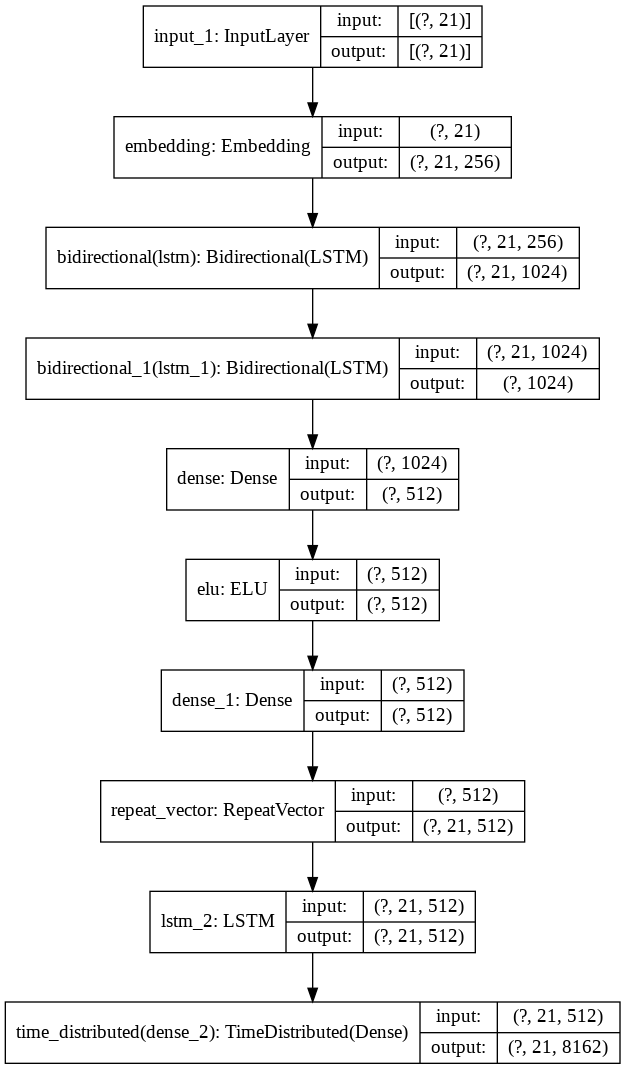

In [20]:
# showing model graph
from tensorflow.keras.utils import plot_model
plot_model(model.ae, to_file= base_path + "AE/" + 'model_plot.png', show_shapes=True, show_layer_names=True)

In [22]:
# Map our Seq to Latent representation using AE
latent_data_set = model.encoder.predict(input_seq)

In [24]:
print(latent_data_set.shape)
print(input_seq.shape)

(12402, 512)
(12402, 21)


In [25]:
def sample_line(wgan_generator):
    noise = np.random.normal(0, 1, (1, 100))
    gen_imgs = wgan_generator.predict(noise)
    sentence = model.generator.predict(gen_imgs)

    middle = word2index['<middle>']
    eos = word2index['<eos>']

    output_sentence_text = []

    for i in range(0, max_len):
        probs = sentence[0][i]
        probs[0] = 0

        idx = 0
        idx = np.argmax(probs)

        if idx == eos:
            output_sentence_text.append(index2word[idx])
            break
        if idx == 0:
            continue
        else:
            output_sentence_text.append(index2word[idx])

    decoded_review2 = ' '.join(output_sentence_text)

    return decoded_review2

In [37]:
# Generate Gan Based on pretrained AE

class WGAN():
    def __init__(self):

        self.size = 512
        self.latent_dim = 100

        self.n_critic = 2
        self.clip_value = 0.01

        # Build and compile the critic
        self.critic = self.build_critic()
        
        self.critic.compile(loss="binary_crossentropy",
            optimizer="adam",
            metrics=['accuracy'])

        
        # Build the generator
        self.generator = self.build_generator()
        

        # The combined model  (stacked generator and critic)
        self.combined = self.define_gan(self.generator, self.critic)
        
    def define_gan(self, generator, critic):
        # make weights in the critic not trainable
        critic.trainable = False
        # connect them
        model = Sequential()
        # add generator
        model.add(generator)
        # add the critic
        model.add(critic)
        
        # compile model
        model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

        return model

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128, input_dim=self.latent_dim))
        model.add(ELU())
        model.add(Dense(256))
        model.add(ELU())
        model.add(Dense(256))
        model.add(ELU())
        model.add(Dense(256))
        model.add(ELU())
        model.add(Dense(self.size, activation='linear'))

        model.summary()
        plot_model(model, to_file= base_path + "Generator/" + 'model_plot.png', show_shapes=True, show_layer_names=True)

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        
        return Model(noise, img)


    
    def build_critic(self):

        model = Sequential()
        model.add(Dense(512, activation='relu', kernel_initializer='he_uniform', input_dim=self.size))
        model.add(Dropout(0.25))
        model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dropout(0.25))
        model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dropout(0.25))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dropout(0.25))
        model.add(Dense(1, activation='sigmoid'))

        model.summary()
        plot_model(model, to_file= base_path + "Discriminator/" + 'model_plot.png', show_shapes=True, show_layer_names=True)

        img = Input(shape=self.size)
        validity = model(img)
        
        return Model(img, validity)

    def train(self, epochs, input_seq, batch_size=128, sample_interval=50):

        X_train = input_seq

        # Adversarial ground truths
        fake = np.zeros((batch_size, 1))
        valid = np.ones((batch_size, 1))

        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                
                # Sample noise as generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Generate a batch of new images
                gen_imgs = self.generator.predict(noise)

                # Train the critic
                d_loss_real = self.critic.train_on_batch(imgs, valid)
                d_loss_fake = self.critic.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

                # Clip critic weights
                for l in self.critic.layers:
                   weights = l.get_weights()
                   weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                   l.set_weights(weights)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.combined.train_on_batch(noise, valid)

            

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                # Plot the progress
                print ("%d [D loss: %f] [G loss: %f]" % (epoch, 1 - d_loss[0], 1 - g_loss[0]))
                self.sample_images()
                checkpoint_path_g = base_path + "Generator/checkpoint.ckpt" 
                checkpoint_path_d = base_path + "Discriminator/checkpoint.ckpt"
                self.generator.save_weights(checkpoint_path_g)
                self.critic.save_weights(checkpoint_path_d)


            if epoch == 20000:
                self.n_critic -= 1

            if self.n_critic < 1 :
                self.n_critic = 1
                

    def sample_images(self):
        print(sample_line(self.generator))


In [39]:
wgan = WGAN()
wgan.train(epochs=40000, input_seq = latent_data_set, batch_size=32, sample_interval=500)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 32)              

In [41]:
wgan.train(epochs=100000, input_seq = latent_data_set, batch_size=32, sample_interval=500)

0 [D loss: 0.348852] [G loss: 0.239885]
رونده ازین ازین ازین چو چو بیدار بیابان دار بیدادی چند چند هنرمند هنرمند هنرمند بدانید بدانید بدانید بدانید بدانید بدانید
500 [D loss: 0.323151] [G loss: 0.292443]
بپریم باید گروگان و یافت افراسیاب <middle> بباید و در تیغ از لب <eos>
1000 [D loss: 0.322067] [G loss: 0.265655]
کشد جوشن و از که کوپال یال <middle> تن و و به دل نباشد او <eos>
1500 [D loss: 0.330441] [G loss: 0.316699]
دل و سو دید برگشت جوی <middle> همان شمشیر گوهر کاخ هاماوران روی <eos>
2000 [D loss: 0.307836] [G loss: 0.309203]
سپهرم یک کشته دید بگذاشت تاج <middle> بیامد و در نامور اندرش پی <eos>
2500 [D loss: 0.334816] [G loss: 0.288480]
چنان هر بخوانی کو را بر بی سال <middle> بر رفت پیمان یکی جاوید لب <eos>
3000 [D loss: 0.344946] [G loss: 0.243880]
نیاسود هر و او پیش از سوار <middle> همه پیمان دشمنان یال آفرید <eos>
3500 [D loss: 0.334378] [G loss: 0.284352]
و دریای سوی ورا گوی پیش <middle> به تخت گیتی آمد دمان بر میان <eos>
4000 [D loss: 0.330850] [G loss: 0.287735]
همی نامور بخ

In [42]:
# load model
wgan = WGAN()
checkpoint_path_g = base_path + "Generator/checkpoint.ckpt" 
checkpoint_path_d = base_path + "Discriminator/checkpoint.ckpt"


wgan.generator.load_weights(checkpoint_path_g)
wgan.critic.load_weights(checkpoint_path_d)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_22 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_56 (Dense)             (None, 32)              

In [44]:
for i in range(10):
    print(sample_line(wgan.generator))


کژی پدر پدر ایران ایران گنج گنج گنج گنج گنج گنج گنج گنج گنج گنج گنج گنج گنج گنج گنج گنج
بیان بند بند بند روان روان روان روان روان روان روان روان بند بند بند بند بند بند بند بند بند
کژی ما گردان گردان گردان گردان گردان و و چشم چشم چشم چشم چشم چشم چشم چشم چشم چشم چشم او
بیان بند بند ستاننده ستاننده جای خون خون گشت خون خون چیزی چیزی چیزی چیزی خون خون چیزی چیزی شان شان
کژی ندادند گراین بندگان بندگان بندگان بندگان بندگان بندگان بندگان بندگان بندگان بندگان بندگان بندگان بندگان بندگان بندگان بندگان بندگان بندگان
چو وی زمان و دستش و نر <middle> ز مردی به برو از ستوه <eos>
که آنکس بودند یابم اندرون روی پیش <middle> به چون بگذرد و ز کار خویش <eos>
که جز تو تو تو تو تو تو تو تو تو تو تو تو تو تو تو تو تو تو تو
میانش شهر ماه و چنگ و چاک <middle> بر شاخ و سر و رنگ اورنگ فر <eos>
همی از نندیشم کزین جهان جهان <middle> کند گنج به به به به به به تو تو و و و نه
